In [1]:
import tensorflow as tf
print(tf.__version__)

C:\Users\nien\Anaconda3\envs\tf1.15+keras2.24\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [3]:
import os

In [4]:
if not os.path.exists("2007_train.txt"):
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd
    sets=[('2007', 'train'), ('2007', 'val')]

  # Pascal VOC 的資料類別
    classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

  # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation(year, image_id, list_file):
        in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult)==1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    wd = "."

    for year, image_set in sets:
        image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
        annotation_path = '%s_%s.txt'%(year, image_set)
        list_file = open(annotation_path, 'w')
        print("save annotation at %s" % annotation_path)
        for image_id in image_ids[:100]: # 只處理 100 張圖片來做範例
            list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
            convert_annotation(year, image_id, list_file)
            list_file.write('\n')
        list_file.close()

In [5]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [6]:
if not os.path.exists("model_data/yolo_weights.h5"):
    print("Converting pretrained YOLOv3 weights for training")
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Pretrained weights exists


In [7]:
annotation_path = '2007_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 2
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 2 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=200,
        initial_epoch=100,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 20 classes.


C:\Users\nien\Anaconda3\envs\tf1.15+keras2.24\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 75) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\Users\nien\Anaconda3\envs\tf1.15+keras2.24\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
C:\Users\nien\Anaconda3\envs\tf1.15+keras2.24\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 75) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\nien\Anaconda3\envs\tf1.15+keras2.24\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
C:\Users\nien\Anaconda3\envs\tf1.15+keras2.24\lib\site-pac

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 90 samples, val on 10 samples, with batch size 2.
Epoch 1/100
45/45 [==============================] - 28s 633ms/step - loss: 2391.6065 - val_loss: 344.4967
Epoch 2/100
45/45 [==============================] - 13s 279ms/step - loss: 224.9281 - val_loss: 185.3257
Epoch 3/100
45/45 [==============================] - 16s 353ms/step - loss: 141.0735 - val_loss: 130.7172
Epoch 4/100
45/45 [==============================] - 12s 276ms/step - loss: 104.7485 - val_loss: 102.5008
Epoch 5/100
45/45 [==============================] - 14s 316ms/step - loss: 84.6368 - val_loss: 82.9841
Epoch 6/100
45/45 [==============================] - 16s 346ms/step - loss: 71.1247 - val_loss: 80.0668
Epoch 7/100
45/45 [==============================] - 14s 310ms/step - loss: 64.3625 - val_loss: 68.3399
Epoch 8/100
45/45 [==============================] - 15s 325ms/step - loss: 55.6946 - val_loss: 59.8927
Epoch 9/10

Epoch 78/100
45/45 [==============================] - 10s 212ms/step - loss: 23.3106 - val_loss: 28.7536
Epoch 79/100
45/45 [==============================] - 10s 212ms/step - loss: 24.8646 - val_loss: 29.7777
Epoch 80/100
45/45 [==============================] - 10s 224ms/step - loss: 23.7276 - val_loss: 30.7548
Epoch 81/100
45/45 [==============================] - 9s 208ms/step - loss: 23.1771 - val_loss: 29.8788
Epoch 82/100
45/45 [==============================] - 10s 211ms/step - loss: 23.7221 - val_loss: 32.2210
Epoch 83/100
45/45 [==============================] - 10s 215ms/step - loss: 23.8706 - val_loss: 30.9520
Epoch 84/100
45/45 [==============================] - 11s 249ms/step - loss: 22.9767 - val_loss: 31.7679
Epoch 85/100
45/45 [==============================] - 10s 229ms/step - loss: 24.7104 - val_loss: 31.7147
Epoch 86/100
45/45 [==============================] - 11s 244ms/step - loss: 24.2136 - val_loss: 29.7310
Epoch 87/100
45/45 [==============================] - 10

In [8]:
from PIL import Image
image = Image.open('../dog.jpg') 

In [9]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 2 boxes for img
dog 0.48 (137, 178) (294, 558)
bicycle 0.84 (241, 133) (505, 469)
3.0529826


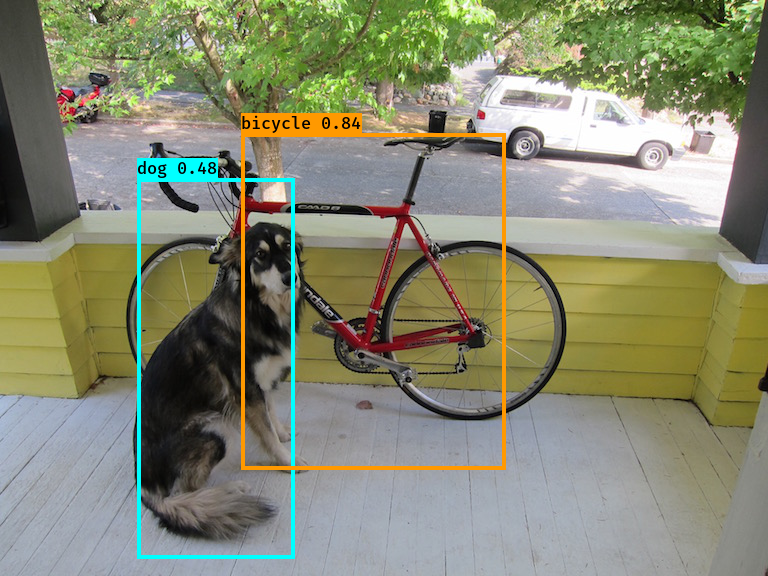

In [10]:
r_image